In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder




In [3]:
df = pd.read_csv("customer_churn_dataset.csv")
df.head()



,customer_id,tenure,monthly_charges,total_charges,contract,payment_method,internet_service,tech_support,online_security,support_calls,churn
0,1,52,54.20,2818.40,Month-to-month,Credit,DSL,No,Yes,1,No
1,2,15,35.28,529.20,Month-to-month,Debit,DSL,No,No,2,No
2,3,72,78.24,5633.28,Month-to-month,Debit,DSL,No,No,0,No
3,4,61,80.24,4894.64,One year,Cash,Fiber,Yes,Yes,0,No
4,5,21,39.38,826.98,Month-to-month,UPI,Fiber,No,No,4,Yes


In [4]:
df = df.drop(["customer_id"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tenure            20000 non-null  int64  
 1   monthly_charges   20000 non-null  float64
 2   total_charges     20000 non-null  float64
 3   contract          20000 non-null  object 
 4   payment_method    20000 non-null  object 
 5   internet_service  17987 non-null  object 
 6   tech_support      20000 non-null  object 
 7   online_security   20000 non-null  object 
 8   support_calls     20000 non-null  int64  
 9   churn             20000 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 1.5+ MB


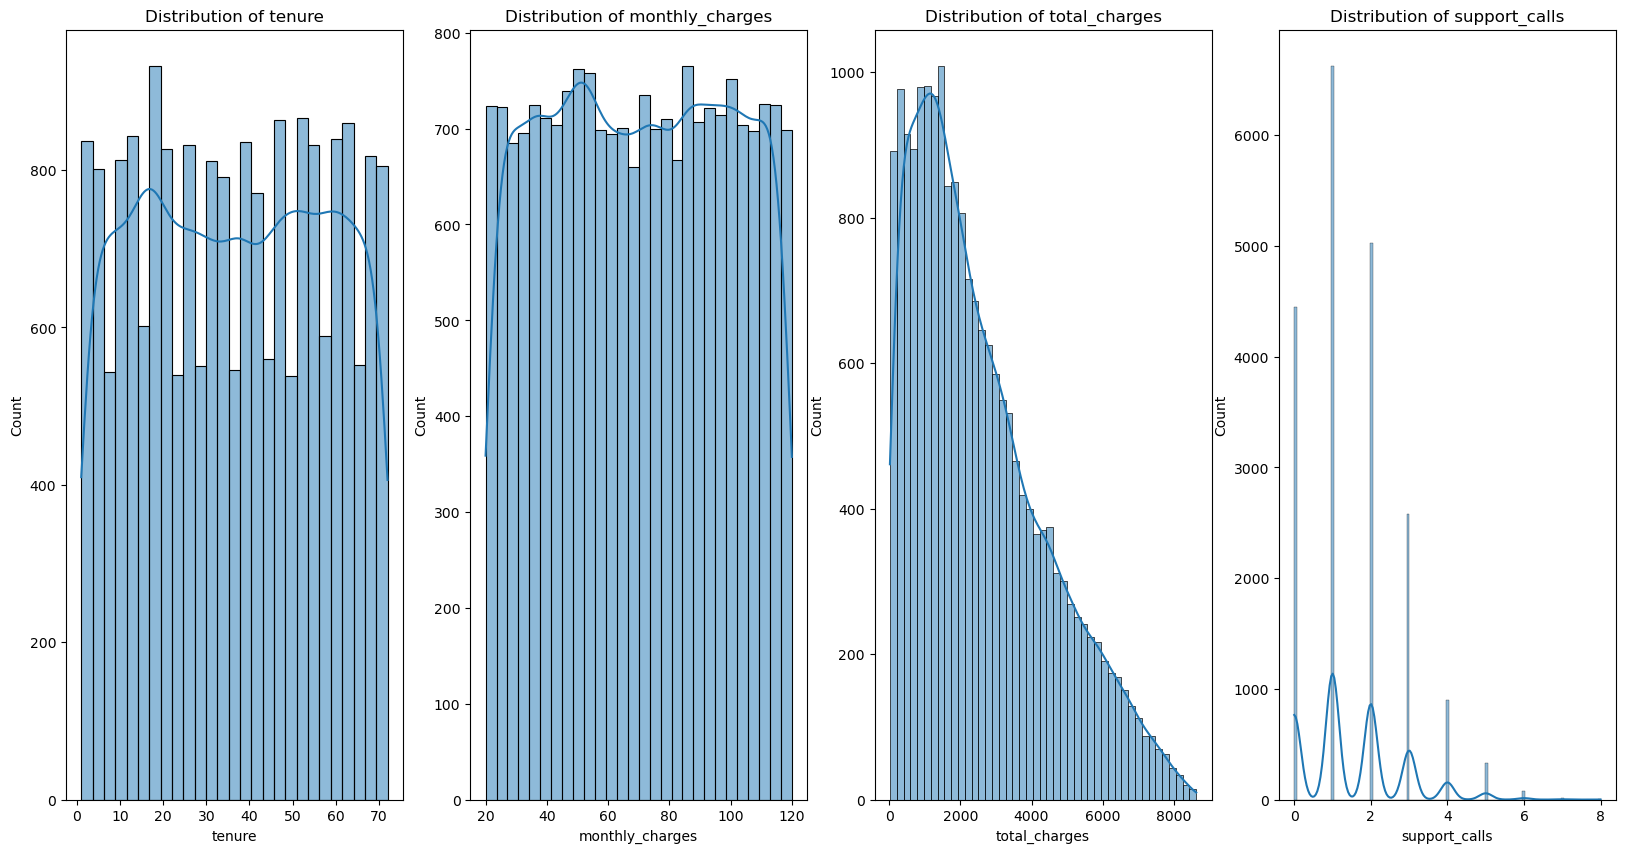

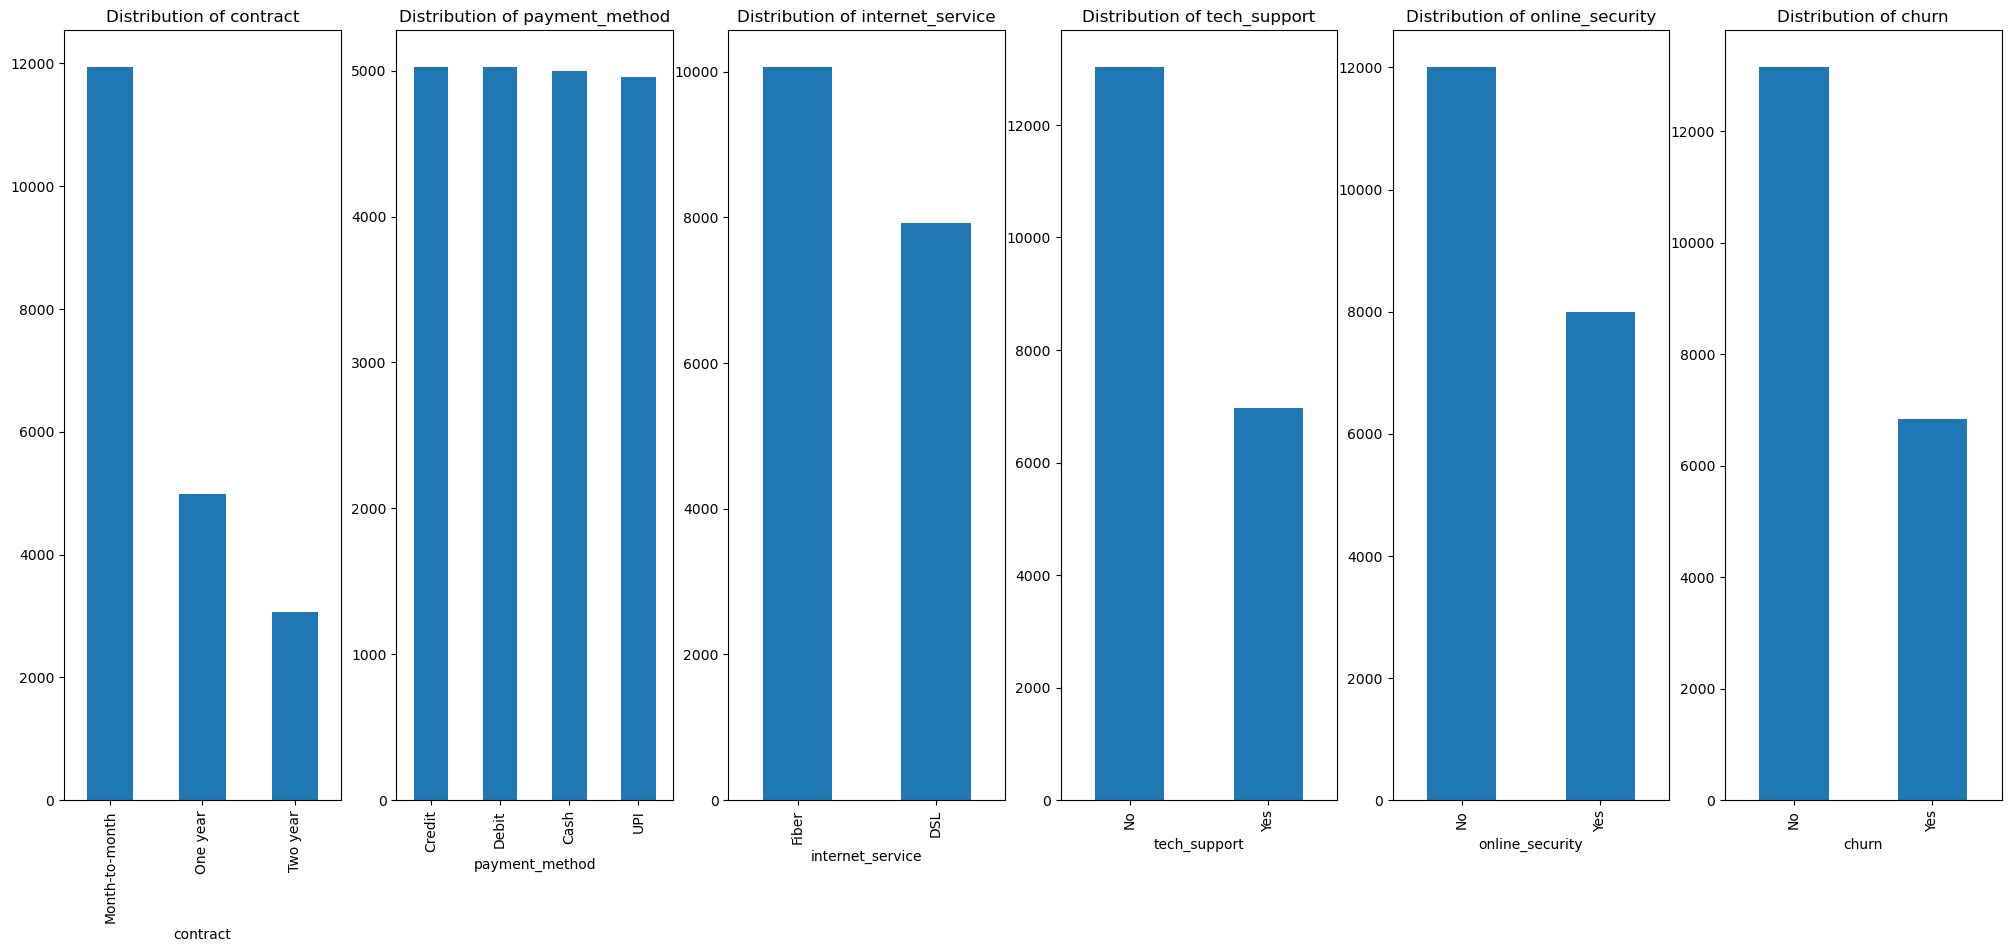

In [5]:
numerical = [i for i in df.columns if df[i].dtype=='int64' or df[i].dtype=='float64']
categorical =[i for i in df.columns if i not in numerical]
fig, axes = plt.subplots(ncols=len(numerical), figsize=(20, 10))
for i, col in enumerate(numerical):
    sns.histplot(df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
fig, axes = plt.subplots(ncols=len(categorical), figsize=(25, 10))
for i, col in enumerate(categorical):
    df[col].value_counts()[:10].plot(kind="bar", ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
     
  

   


interval columns not set, guessing: ['tenure', 'monthly_charges', 'total_charges', 'support_calls']


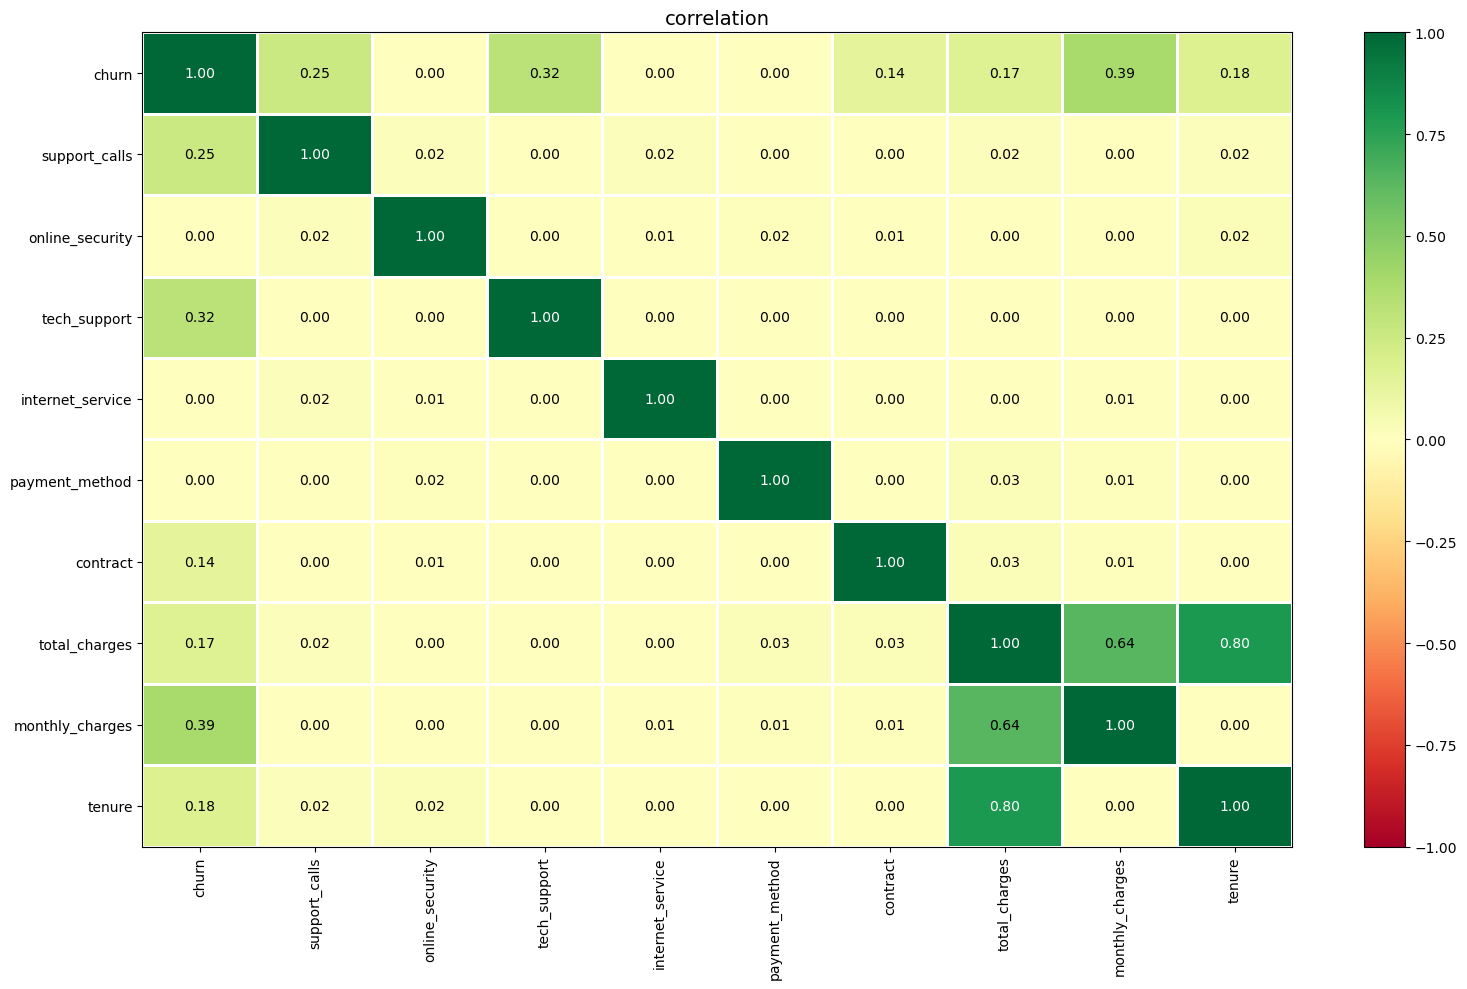

In [6]:
corr_matrix = df.phik_matrix()
plot_correlation_matrix(corr_matrix.values, x_labels = corr_matrix.columns, y_labels = corr_matrix.index, figsize=(16,10))

In [ ]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)git add README.md

In [ ]:
def prepare_catboost_data(X, categorical_indices):
   
    if isinstance(X, pd.DataFrame):
        X_cb = X.copy()

        for idx in categorical_indices:
            col_name = X_cb.columns[idx]

            X_cb[col_name] = (
                X_cb[col_name]
                .fillna("__MISSING__")
                .astype(str)
            )

        return X_cb

    elif isinstance(X, np.ndarray):
        X_cb = X.copy()

        for idx in categorical_indices:
            col = X_cb[:, idx]
            col = np.where(pd.isna(col), "__MISSING__", col)
            X_cb[:, idx] = col.astype(str)

        return X_cb

    else:
        raise TypeError("X must be pandas DataFrame or numpy ndarray")

In [ ]:
def display_results(results_df, classification_reports, confusion_matrices):


    print("\n" + "=" * 100)
    print("SUMMARY RESULTS (ALL MODELS)")
    print("=" * 100)

    print(
        results_df[
            ['Model', 'Test Accuracy (%)', 'Test Precision (%)',
             'Test Recall (%)', 'Test F1 (%)', 'Test ROC-AUC (%)']
        ].to_string(index=False)
    )

    for _, row in results_df.iterrows():
        model_name = row['Model']

        print("\n" + "=" * 100)
        print(f"MODEL: {model_name}")
        print("=" * 100)

        print(f"Best Params: {row['Best Params']}")
        if 'Best CV F1 (%)' in results_df.columns:
            print(f"Best CV F1: {row['Best CV F1 (%)']}%")

        print(f"Test Accuracy: {row['Test Accuracy (%)']}%")
        print(f"Test Precision: {row['Test Precision (%)']}%")
        print(f"Test Recall: {row['Test Recall (%)']}%")
        print(f"Test F1: {row['Test F1 (%)']}%")
        print(f"Test ROC-AUC: {row['Test ROC-AUC (%)']}%")

        print("\nClassification Report:")
        print("-" * 60)

        report_df = pd.DataFrame(classification_reports[model_name]).transpose()
        print(report_df.to_string())

        cm = confusion_matrices[model_name]

        print("\nConfusion Matrix:")
        print("-" * 60)
        print(cm)

        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix — {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    # =========================
    # METRICS COMPARISON PLOT
    # =========================
    metrics_df = results_df[
        ['Model', 'Test Accuracy (%)', 'Test Precision (%)',
         'Test Recall (%)', 'Test F1 (%)']
    ].set_index('Model')

    metrics_df.plot(kind='bar', figsize=(10, 5))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score (%)')
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [14]:
df

,tenure,monthly_charges,total_charges,contract,payment_method,internet_service,tech_support,online_security,support_calls,churn
0,52,54.20,2818.40,Month-to-month,Credit,DSL,No,Yes,1,No
1,15,35.28,529.20,Month-to-month,Debit,DSL,No,No,2,No
2,72,78.24,5633.28,Month-to-month,Debit,DSL,No,No,0,No
3,61,80.24,4894.64,One year,Cash,Fiber,Yes,Yes,0,No
4,21,39.38,826.98,Month-to-month,UPI,Fiber,No,No,4,Yes
...,...,...,...,...,...,...,...,...,...,...
19995,36,69.51,2502.36,Two year,Cash,DSL,No,Yes,0,Yes
19996,10,59.88,598.80,Month-to-month,UPI,Fiber,Yes,No,1,No
19997,6,42.96,257.76,Month-to-month,Credit,Fiber,No,No,2,No
19998,7,102.85,719.95,Month-to-month,Debit,DSL,Yes,No,2,No


In [ ]:
def train_with_halving_search(
    x_train, y_train,
    x_test, y_test,
    numerical_indices,
    categorical_indices
):
   
    
    sklearn_preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_indices),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_indices)
        ]
    )

    pipelines = {
        "Random Forest": Pipeline([
            ('preprocessor', sklearn_preprocessor),
            ('model', RandomForestClassifier(
                random_state=42,
                class_weight='balanced'
            ))
        ]),

        "Logistic Regression": Pipeline([
            ('preprocessor', sklearn_preprocessor),
            ('model', LogisticRegression(
                max_iter=2000,
                random_state=42,
                class_weight='balanced'
            ))
        ]),

        "SVC": Pipeline([
            ('preprocessor', sklearn_preprocessor),
            ('model', SVC(
                probability=True,
                random_state=42,
                class_weight='balanced'
            ))
        ])
    }

    param_grids = {
        "Random Forest": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        },

        "Logistic Regression": {
            'model__C': [0.01, 0.1, 1, 10]
        },

        "SVC": {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    }

    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    )

    results = []
    best_models = {}
    reports = {}
    confusion_matrices = {}
    predictions = {}

    for model_name, pipeline in pipelines.items():

        print(f"\n{'=' * 70}")
        print(f"Training: {model_name}")
        print(f"{'=' * 70}")

        search = HalvingGridSearchCV(
            estimator=pipeline,
            param_grid=param_grids[model_name],
            factor=2,
            cv=cv,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )

        search.fit(x_train, y_train)

        best_model = search.best_estimator_
        y_pred = best_model.predict(x_test)

        y_pred_proba = (
            best_model.predict_proba(x_test)[:, 1]
            if hasattr(best_model, "predict_proba")
            else None
        )

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        roc_auc = None
        if y_pred_proba is not None:
            roc_auc = roc_auc_score(y_test, y_pred_proba)

        results.append({
            "Model": model_name,
            "Best Params": str(search.best_params_),
            "Best CV F1 (%)": round(search.best_score_ * 100, 2),
            "Test Accuracy (%)": round(acc * 100, 2),
            "Test Precision (%)": round(prec * 100, 2),
            "Test Recall (%)": round(rec * 100, 2),
            "Test F1 (%)": round(f1 * 100, 2),
            "Test ROC-AUC (%)": round(roc_auc * 100, 2) if roc_auc else None
        })

        best_models[model_name] = best_model
        reports[model_name] = classification_report(y_test, y_pred, output_dict=True)
        confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)
        predictions[model_name] = {
            "y_pred": y_pred,
            "y_pred_proba": y_pred_proba
        }

        print(f"✓ Best params: {search.best_params_}")
        print(f"✓ CV F1: {search.best_score_:.4f}")
        print(f"✓ Test F1: {f1:.4f}")

    print(f"\n{'=' * 70}")
    print("Training: CatBoost")
    print(f"{'=' * 70}")
    x_train_cb = prepare_catboost_data(x_train, categorical_indices)
    x_test_cb = prepare_catboost_data(x_test, categorical_indices)

    cat_model = CatBoostClassifier(
        iterations=300,
        depth=6,
        learning_rate=0.05,
        auto_class_weights='Balanced',
        random_state=42,
        verbose=False
    )

    cat_model.fit(
        x_train_cb,
        y_train,
        cat_features=categorical_indices
    )

    y_pred = cat_model.predict(x_test_cb)
    y_pred_proba = cat_model.predict_proba(x_test_cb)[:, 1]

    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        "Model": "CatBoost",
        "Best Params": "Manual",
        "Best CV F1 (%)": None,
        "Test Accuracy (%)": round(accuracy_score(y_test, y_pred) * 100, 2),
        "Test Precision (%)": round(precision_score(y_test, y_pred, average='weighted') * 100, 2),
        "Test Recall (%)": round(recall_score(y_test, y_pred, average='weighted') * 100, 2),
        "Test F1 (%)": round(f1 * 100, 2),
        "Test ROC-AUC (%)": round(roc_auc_score(y_test, y_pred_proba) * 100, 2)
    })

    best_models["CatBoost"] = cat_model
    reports["CatBoost"] = classification_report(y_test, y_pred, output_dict=True)
    confusion_matrices["CatBoost"] = confusion_matrix(y_test, y_pred)
    predictions["CatBoost"] = {
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba
    }

    results_df = pd.DataFrame(results).sort_values(
        "Test F1 (%)", ascending=False
    )

    return results_df, best_models, reports, confusion_matrices, predictions



Training: Random Forest
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1000
max_resources_: 16000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 1000
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 1
n_candidates: 12
n_resources: 2000
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 6
n_resources: 4000
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 3
n_resources: 8000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 4
n_candidates: 2
n_resources: 16000
Fitting 5 folds for each of 2 candidates, totalling 10 fits
✓ Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
✓ CV F1: 0.8401
✓ Test F1: 0.8514

Training: Logistic Regression
n_iterations: 3
n_required_iterations: 3
n_possible_iteration

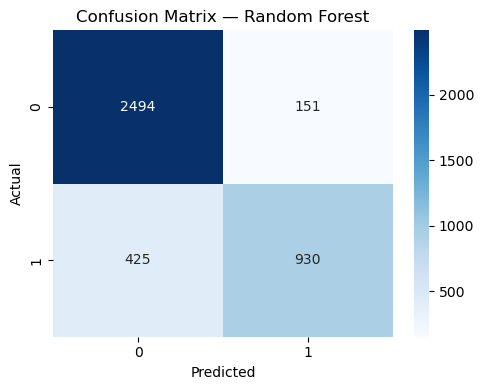


MODEL: CatBoost
Best Params: Manual
Best CV F1: nan%
Test Accuracy: 85.55%
Test Precision: 85.57%
Test Recall: 85.55%
Test F1: 85.1%
Test ROC-AUC: 82.04%

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score    support
No             0.854545  0.941777  0.896043  2645.0000
Yes            0.858065  0.687085  0.763115  1355.0000
accuracy       0.855500  0.855500  0.855500     0.8555
macro avg      0.856305  0.814431  0.829579  4000.0000
weighted avg   0.855738  0.855500  0.851014  4000.0000

Confusion Matrix:
------------------------------------------------------------
[[2491  154]
 [ 424  931]]


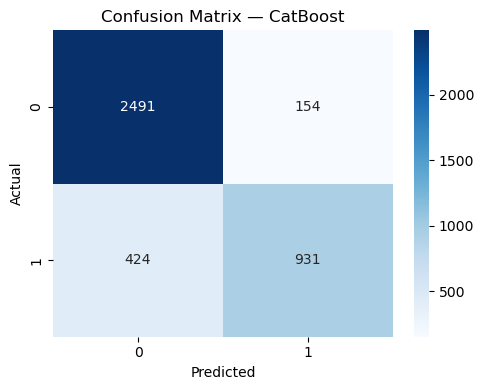


MODEL: SVC
Best Params: {'model__C': 10, 'model__kernel': 'rbf'}
Best CV F1: 80.62%
Test Accuracy: 82.27%
Test Precision: 82.01%
Test Recall: 82.27%
Test F1: 82.07%
Test ROC-AUC: 81.54%

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score     support
No             0.850471  0.888091  0.868874  2645.00000
Yes            0.760905  0.695203  0.726572  1355.00000
accuracy       0.822750  0.822750  0.822750     0.82275
macro avg      0.805688  0.791647  0.797723  4000.00000
weighted avg   0.820130  0.822750  0.820669  4000.00000

Confusion Matrix:
------------------------------------------------------------
[[2349  296]
 [ 413  942]]


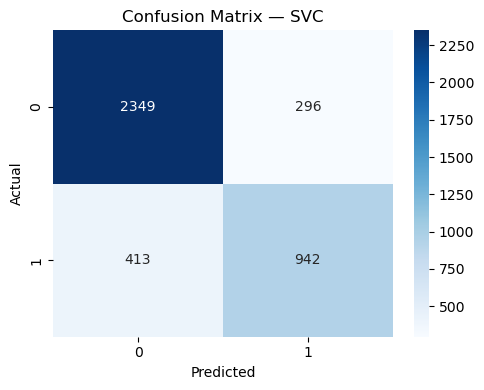


MODEL: Logistic Regression
Best Params: {'model__C': 10}
Best CV F1: 71.57%
Test Accuracy: 72.22%
Test Precision: 74.87%
Test Recall: 72.22%
Test F1: 72.87%
Test ROC-AUC: 79.11%

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score     support
No             0.840284  0.716068  0.773219  2645.00000
Yes            0.569874  0.734317  0.641728  1355.00000
accuracy       0.722250  0.722250  0.722250     0.72225
macro avg      0.705079  0.725193  0.707474  4000.00000
weighted avg   0.748683  0.722250  0.728677  4000.00000

Confusion Matrix:
------------------------------------------------------------
[[1894  751]
 [ 360  995]]


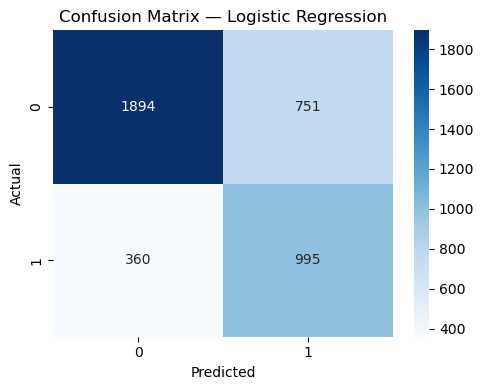

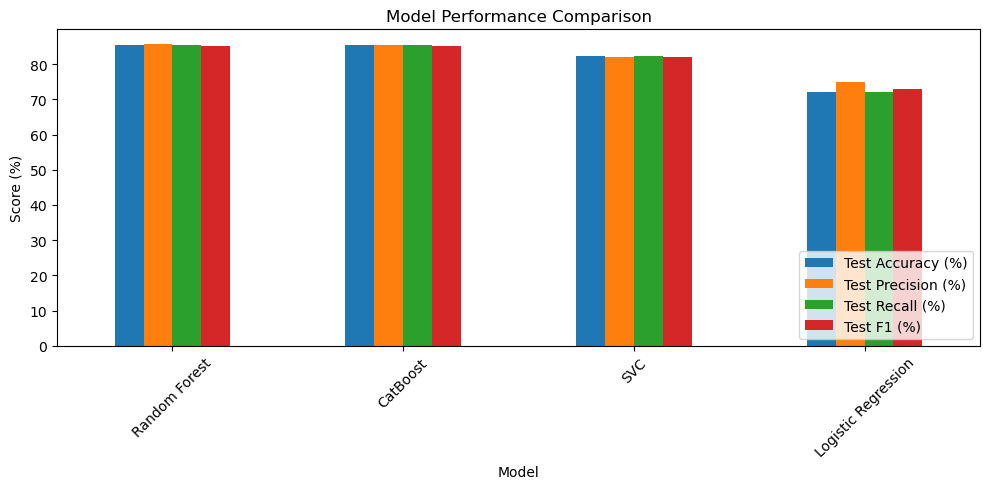

In [ ]:
numerical_indices = [0, 1, 2, 8]
categorical_indices = [3, 4, 5, 6, 7]

# Обучение моделей
results_df, best_models, reports, matrices, predictions = train_with_halving_search(
    x_train, y_train,
    x_test, y_test,
    numerical_indices, categorical_indices
)

display_results(results_df, reports, matrices)